# Import Libraries / Verify Setup

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE

# Running on 2021 Macbook Pro
start_time = time.time()

# Import Data

In [3]:
raw = pd.read_csv("../Data/diabetes2_raw.csv")
raw.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Data Cleaning

In [4]:
# Make a copy of the data
data = raw.copy(deep=True)

In [5]:
# Drop pre-diabetes patients
data = data[data["Diabetes_012"]!=1]
data["Diabetes"] = data["Diabetes_012"].apply(lambda x: 1 if x > 0 else 0)
data.drop(["Diabetes_012"],axis=1,inplace=True)
data = data.reset_index(drop=True)

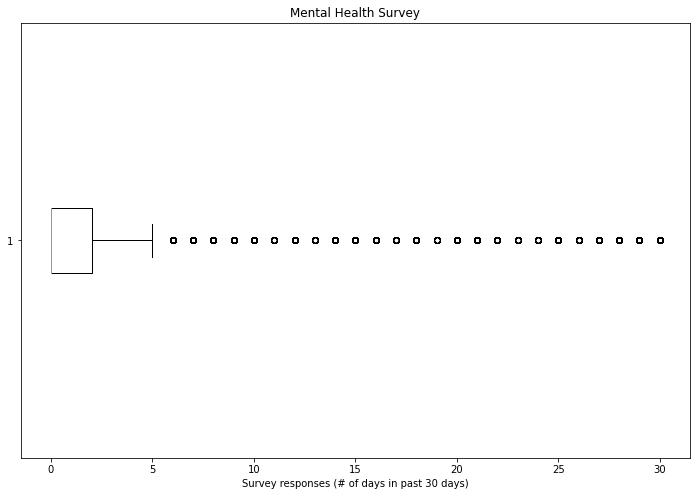

In [6]:
# Mental health feature engineering (binning approach)
plt.figure(figsize=(12,8))
plt.boxplot(data["MentHlth"],vert=False)
plt.xlabel("Survey responses (# of days in past 30 days)")
plt.title("Mental Health Survey")
plt.show()

mental_health = []
good = np.median(data["MentHlth"])
medium = np.quantile(data["MentHlth"],0.75) +\
         1.5*(np.quantile(data["MentHlth"],0.75)-np.quantile(data["MentHlth"],0.25))
for i in range(len(data)):
    if data["MentHlth"][i] <= good:
        mental_health.append(0)
    elif data["MentHlth"][i] <= medium:
        mental_health.append(1)
    else:
        mental_health.append(2)     
data["Mental_Health"] = mental_health
data.drop(["MentHlth"],axis=1,inplace=True)

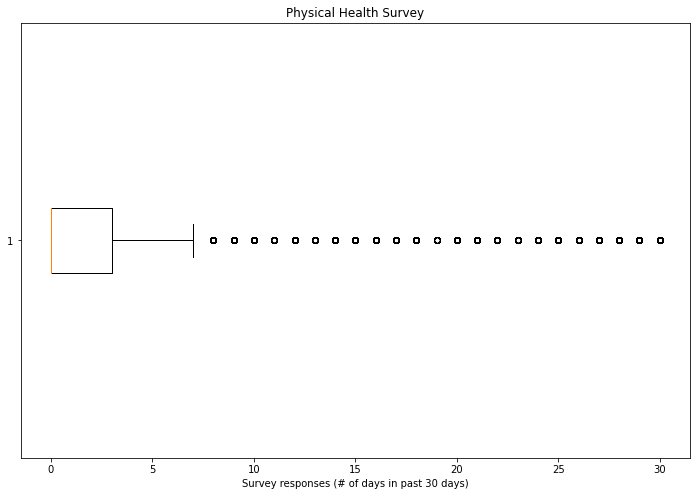

In [7]:
# Physical health feature engineering (binning approach)
plt.figure(figsize=(12,8))
plt.boxplot(data["PhysHlth"],vert=False)
plt.xlabel("Survey responses (# of days in past 30 days)")
plt.title("Physical Health Survey")
plt.show()

physical_health = []
good = np.median(data["PhysHlth"])
medium = np.quantile(data["PhysHlth"],0.75) +\
         1.5*(np.quantile(data["PhysHlth"],0.75)-np.quantile(data["PhysHlth"],0.25))
for i in range(len(data)):
    if data["PhysHlth"][i] <= good:
        physical_health.append(0)
    elif data["PhysHlth"][i] <= medium:
        physical_health.append(1)
    else:
        physical_health.append(2)
data["Physical_Health"] = physical_health
data.drop(["PhysHlth"],axis=1,inplace=True)

In [8]:
# General health feature cleaning (change to 1=bad, 5=good)
general_health = []
for i in range(len(data)):
    if data["GenHlth"][i] == 1:
        general_health.append(5)
    elif data["GenHlth"][i] == 2:
        general_health.append(4)
    elif data["GenHlth"][i] == 3:
        general_health.append(3)
    elif data["GenHlth"][i] == 4:
        general_health.append(2)
    else:
        general_health.append(1)
data["General_Health_Survey"] = general_health
data.drop(["GenHlth"],axis=1,inplace=True)

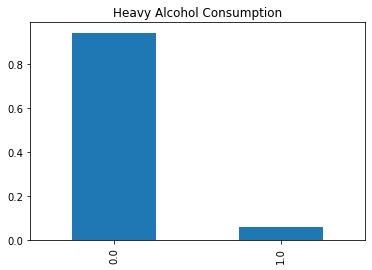

Heavy Alcohol Consumption -> Diabetes Correlation: -0.0579


In [9]:
# Remove heavy alcohol consumption feature (biased feature)
data["HvyAlcoholConsump"].value_counts(normalize=True).plot(kind="bar")
plt.title("Heavy Alcohol Consumption")
plt.show()

corr = data[["HvyAlcoholConsump","Diabetes"]].corr().values[0,1]
print(f"Heavy Alcohol Consumption -> Diabetes Correlation: {corr:.4f}")

data.drop(["HvyAlcoholConsump"],axis=1,inplace=True)

In [10]:
# Rename columns
data.columns = [
    "High_BP",
    "High_Chol",
    "Chol_Check",
    "BMI",
    "Smoker",
    "Stroke",
    "Heart_Disease_Attack",
    "Physical_Activity",
    "Fruits",
    "Veggies",
    "Healthcare",
    "No_Doctor_Cost",
    "Difficulty_Walk",
    "Sex",
    "Age",
    "Education",
    "Income",
    "Diabetes",
    "Mental_Health_Survey",
    "Physical_Health_Survey",
    "General_Health_Survey"
]

In [11]:
# Class imbalance
print(f"Number of rows: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")
print()
print(f"Class Imbalance: {data['Diabetes'].sum()/len(data):.4f}")
print(data["Diabetes"].value_counts())
print()
print(f"Baseline Accuracy: {(len(data)-data['Diabetes'].sum())/len(data):.4f}")

Number of rows: 249049
Number of features: 21

Class Imbalance: 0.1419
0    213703
1     35346
Name: Diabetes, dtype: int64

Baseline Accuracy: 0.8581


In [12]:
# Independent/dependent variables
X = data.drop(["Diabetes"],axis=1)
y = data["Diabetes"]

In [13]:
# Standardization
X_std = (X - np.mean(X,axis=0))/(np.std(X,axis=0))

In [14]:
# Train/test split (80/20)
sss = StratifiedShuffleSplit(n_splits=1,test_size=.2,random_state=15774)
for train_index,test_index in sss.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    X_train_std,X_test_std = X_std.iloc[train_index],X_std.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

# Supervised Learning

##### Helper Functions

In [15]:
def find_optimal_cutoff(target,predicted):
    """
    Helper function to find the optimal threshold for a classification model
    
    Inputs:
        target - array, target data
        predicted - array, predicted data
    Outputs
        optimum - float, optimal cutoff value
        
    The optimal cut off point would be where tpr is high and fpr is low.
    When [tpr - (1-fpr)] is zero or near to zero, this is the optimal threshold.
    """
    fpr,tpr,threshold = metrics.roc_curve(target,predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({"tf":pd.Series(tpr-(1-fpr),index=i),"threshold":pd.Series(threshold,index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    optimum = roc_t["threshold"].values[0]
    return(optimum)

In [16]:
def classification_evaluation(model,X_train,y_train,X_test,y_test,t=0.5):
    """
    Helper function to evaluate classification models in a consistent manner
    
    Inputs:
        model - scikit-learn classification model
        X_train - dataframe, training data
        y_train - array, training labels
        X_test - dataframe, testing data
        y_test - array, testing labels
        t - float, threshold
    Outputs:
        auc - float, test AUC
        accuracy - float, test accuracy
    """
    # Determine model predictions
    train_pred = model.predict_proba(X_train)[:,1]
    test_pred = model.predict_proba(X_test)[:,1]
    train_fpr,train_tpr,_ = metrics.roc_curve(y_train,train_pred)
    test_fpr,test_tpr,_ = metrics.roc_curve(y_test,test_pred)   
    # Print AUC and Accuracy
    print(f"Train AUC: {metrics.roc_auc_score(y_train,train_pred):.4f}")
    print(f"Test AUC: {metrics.roc_auc_score(y_test,test_pred):.4f}")
    print(f"Train Accuracy: {metrics.accuracy_score(y_train,train_pred>t):.4f}")
    print(f"Test Accuracy: {metrics.accuracy_score(y_test,test_pred>t):.4f}")
    auc = metrics.roc_auc_score(y_test,test_pred)
    accuracy = metrics.accuracy_score(y_test,test_pred>t)
    # Plot the roc curve for the model
    plt.plot(train_fpr,train_tpr,linestyle="--",label="Train")
    plt.plot(test_fpr,test_tpr,marker=".",label="Test")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    # Return test AUC and accuracy
    return (auc,accuracy)

##### Logistic Regression

In [17]:
# Define the grid that we want to search over
param_grid = {"C": np.arange(0.001,1,0.05), 
              "penalty": ["l2","l1"], 
              "solver": ["liblinear"]}
# Define the parameters for the model 
gs = GridSearchCV(LogisticRegression(max_iter=1000),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring="roc_auc",
                  cv=5,
                  verbose=0,
                  n_jobs=-1)
# Fit the model (standardized data)
gs.fit(X_train_std,y_train)
m_lr = gs.best_estimator_
print("Best parameters: ",gs.best_params_)

Best parameters:  {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [18]:
# Examine coefficients
coef_output = pd.DataFrame({"feature":X_train.columns,"coefficient":m_lr.coef_[0]})
print("Sparsity: %d" % (coef_output.query("coefficient == 0").shape[0]))
coef_output.sort_values("coefficient")

Sparsity: 0


,feature,coefficient
19,General_Health_Survey,-0.482619
16,Income,-0.105803
15,Education,-0.041592
17,Mental_Health_Survey,-0.041277
7,Physical_Activity,-0.024446
4,Smoker,-0.017130
8,Fruits,-0.015639
18,Physical_Health_Survey,-0.011690
9,Veggies,-0.008793
11,No_Doctor_Cost,0.001222


Train AUC: 0.7860
Test AUC: 0.7843
Train Accuracy: 0.7136
Test Accuracy: 0.7126


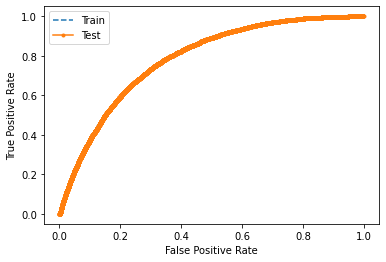

In [19]:
# Evaluation
threshold = find_optimal_cutoff(y_train,m_lr.predict_proba(X_train)[:,1])
m_lr_auc,m_lr_accuracy = classification_evaluation(m_lr,X_train,y_train,X_test,y_test,threshold)

##### Decision Tree

In [20]:
# Define the grid that we want to search over
param_grid = {"max_depth": np.arange(2,4,1),
              "criterion": ["gini","entropy"],
              "class_weight": ["balanced"]}
# Define the parameters for the model 
gs = GridSearchCV(DecisionTreeClassifier(),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring="roc_auc",
                  cv=5,
                  verbose=0,
                  n_jobs=-1)
# Fit the model
gs.fit(X_train,y_train)
m_cart = gs.best_estimator_
print("Best parameters: ",gs.best_params_)

Best parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3}


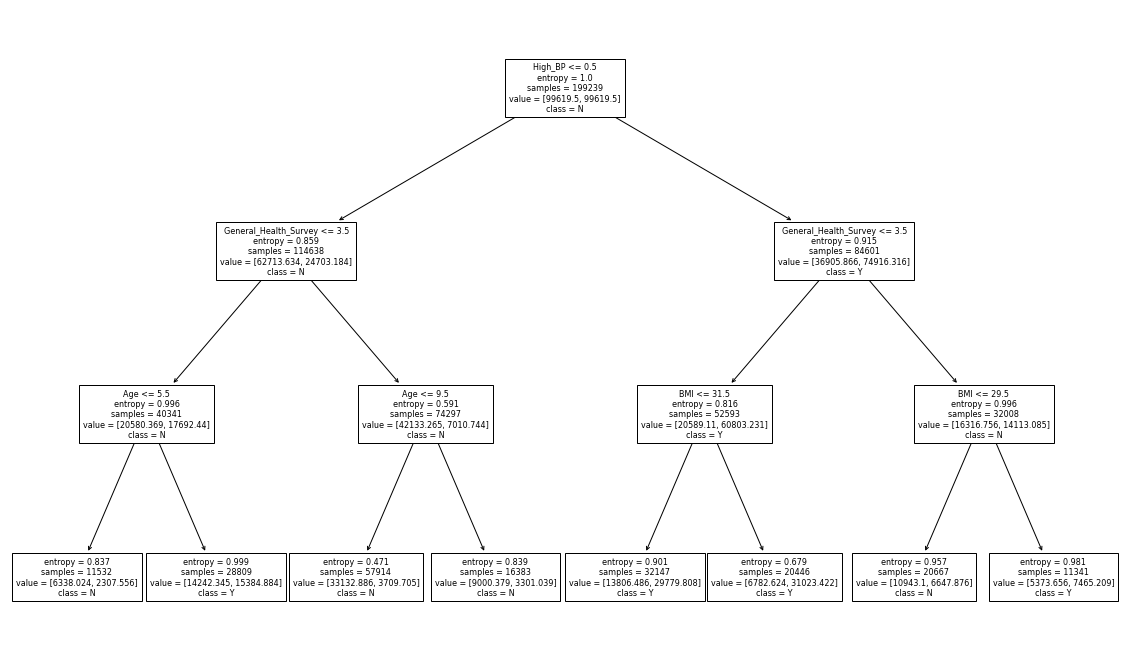

In [21]:
# Examine tree
plt.figure(figsize=(20,12))
plot_tree(m_cart,feature_names=X_train.columns,filled=False,fontsize=8,class_names=["N","Y"])
plt.show()

Train AUC: 0.7847
Test AUC: 0.7838
Train Accuracy: 0.7674
Test Accuracy: 0.7676


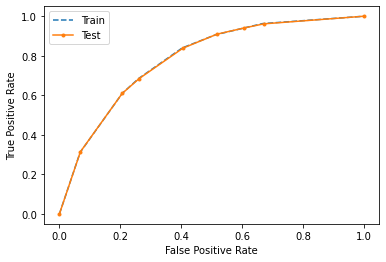

In [22]:
# Evaluation
threshold = find_optimal_cutoff(y_train,m_cart.predict_proba(X_train)[:,1])
m_cart_auc,m_cart_accuracy = classification_evaluation(m_cart,X_train,y_train,X_test,y_test,threshold)

##### XGBoost

In [23]:
# Define the parameter grid
param_grid = {"n_estimators": [100,200],
              "max_depth": np.arange(2,6,1)}
# Define the parameters for the model 
gs = GridSearchCV(xgb.XGBClassifier(eval_metric="logloss"),
                  return_train_score=True, 
                  param_grid=param_grid, 
                  scoring="roc_auc",
                  cv=5,
                  verbose=0,
                  n_jobs=-1)
# Fit the model
gs.fit(X_train,y_train)
m_xgb = gs.best_estimator_
print("Best parameters: ",gs.best_params_)

Best parameters:  {'max_depth': 3, 'n_estimators': 200}


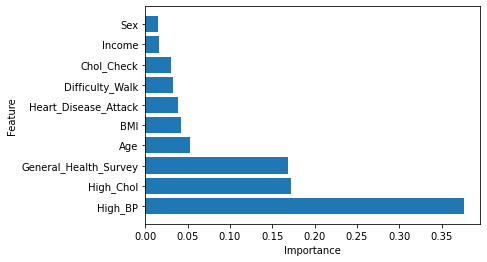

In [24]:
# Interpret output
importance_output = pd.DataFrame({"feature":X_train.columns,
                                  "importance":m_xgb.feature_importances_}).sort_values("importance",ascending=False)
plt.barh(importance_output["feature"][0:10],importance_output["importance"][0:10])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

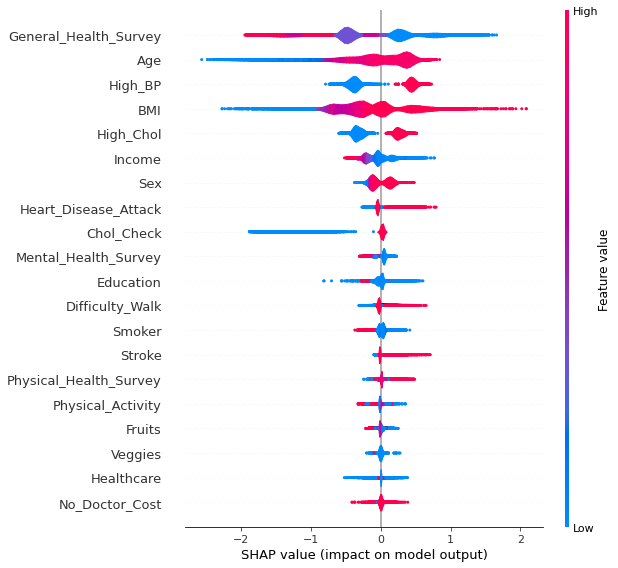

In [25]:
# Shapley plot
explainer = shap.TreeExplainer(m_xgb)
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X_train,show=True,max_display=20,plot_type="violin")
plt.show()

Train AUC: 0.8395
Test AUC: 0.8333
Train Accuracy: 0.7587
Test Accuracy: 0.7541


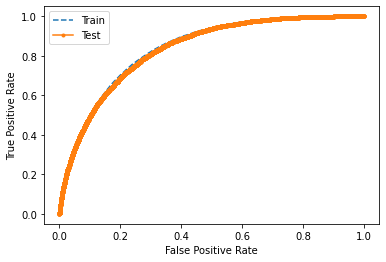

In [26]:
# Evaluation
threshold = find_optimal_cutoff(y_train,m_xgb.predict_proba(X_train)[:,1])
m_xgb_auc,m_xgb_accuracy = classification_evaluation(m_xgb,X_train,y_train,X_test,y_test,threshold)

# Results

In [27]:
names = ["Logistic Regression","Decision Tree","XGBoost"]
auc_res = [m_lr_auc,m_cart_auc,m_xgb_auc]
acc_res = [m_lr_accuracy,m_cart_accuracy,m_xgb_accuracy]

pd.DataFrame({"Model":names,
              "Testing AUC":auc_res,
              "Testing Accuracy":acc_res}).sort_values(by="Testing AUC",ascending=False).reset_index(drop=True)

,Model,Testing AUC,Testing Accuracy
0,XGBoost,0.833296,0.754065
1,Logistic Regression,0.784348,0.712608
2,Decision Tree,0.783767,0.767557


# Oversampling

In [28]:
def imbalanced_evaluation(X_train,y_train,X_test,y_test,technique):
    """
    Function to evaluate XGBoost performance using data balancing techniques

    Inputs:
        X_train - dataframe, training data
        y_train - array, training labels
        X_test - dataframe, testing data
        y_test - array, testing labels
        technique - string, technique to balance data
    Outputs:
        model - fitted XGBoost model
        auc - float, test AUC
        accuracy - float, test accuracy

    The parameter "technique" represents the data balancing technique we want to use.
    This parameter can take on the following values:
        None - no technique is used
        "upsampling" - random upsampling is used
        "undersampling" - random undersampling is used
        "smote" - SMOTE is used
    """
    # Determine minority class
    neg_n = (y_train == 0).sum()
    pos_n = (y_train == 1).sum()
    assert(neg_n + pos_n == len(y_train))
    if neg_n > pos_n:
        minority_class = 1
        majority_class = 0
        minority_class_n = pos_n
        majority_class_n = neg_n
    else:
        minority_class = 0
        majority_class = 1
        minority_class_n = neg_n
        majority_class_n = pos_n
    # Balance training data
    if technique == None:
        X_train_bal = X_train
        y_train_bal = y_train
    elif technique == "upsampling":
        num_to_sample = majority_class_n - minority_class_n
        generated_data = resample(X_train[y_train==minority_class],
                                  replace=True,
                                  n_samples=num_to_sample)
        X_train_bal = pd.concat([X_train,generated_data])
        y_train_bal = np.concatenate([y_train,np.repeat(minority_class,num_to_sample)])
    elif technique == "undersampling":
        num_to_sample = minority_class_n
        generated_data = resample(X_train[y_train==majority_class],
                                  replace=False,
                                  n_samples=num_to_sample)
        X_train_bal = pd.concat([X_train[y_train==minority_class],generated_data])
        y_train_bal = np.concatenate([y_train[y_train==minority_class],np.repeat(majority_class,num_to_sample)])
    elif technique == "smote":
        sm = SMOTE(random_state=15774)
        X_train_bal,y_train_bal = sm.fit_resample(X_train,y_train)
    else:
        raise ValueError("Invalid technique")
    # Fit model
    param_grid = {"n_estimators": [100,200],
                  "max_depth": np.arange(2,6,1)}
    gs = GridSearchCV(xgb.XGBClassifier(eval_metric="logloss"),
                                        return_train_score=True, 
                                        param_grid=param_grid, 
                                        scoring="roc_auc",
                                        cv=5,
                                        verbose=0,
                                        n_jobs=-1)
    gs.fit(X_train_bal,y_train_bal)
    model = gs.best_estimator_
    # Evaluation
    threshold = find_optimal_cutoff(y_train_bal,model.predict_proba(X_train_bal)[:,1])
    auc,accuracy = classification_evaluation(model,X_train,y_train,X_test,y_test,threshold)
    return (model,auc,accuracy)

##### Upsampling

Train AUC: 0.8565
Test AUC: 0.8280
Train Accuracy: 0.7749
Test Accuracy: 0.7619


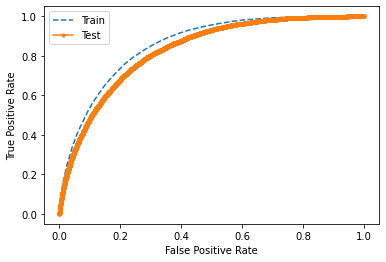

In [29]:
upsampling = imbalanced_evaluation(X_train,y_train,X_test,y_test,"upsampling")

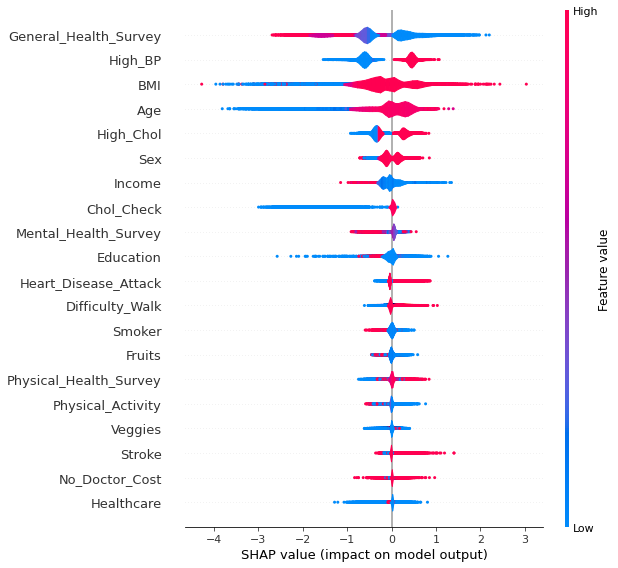

In [30]:
explainer = shap.TreeExplainer(upsampling[0])
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X_train,show=True,max_display=20,plot_type="violin")
plt.show()

##### Undersampling

Train AUC: 0.8361
Test AUC: 0.8328
Train Accuracy: 0.7536
Test Accuracy: 0.7495


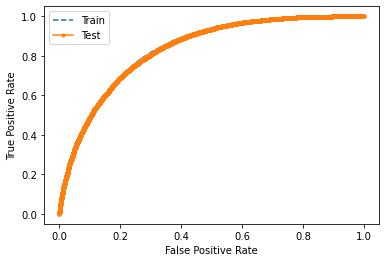

In [31]:
undersampling = imbalanced_evaluation(X_train,y_train,X_test,y_test,"undersampling")

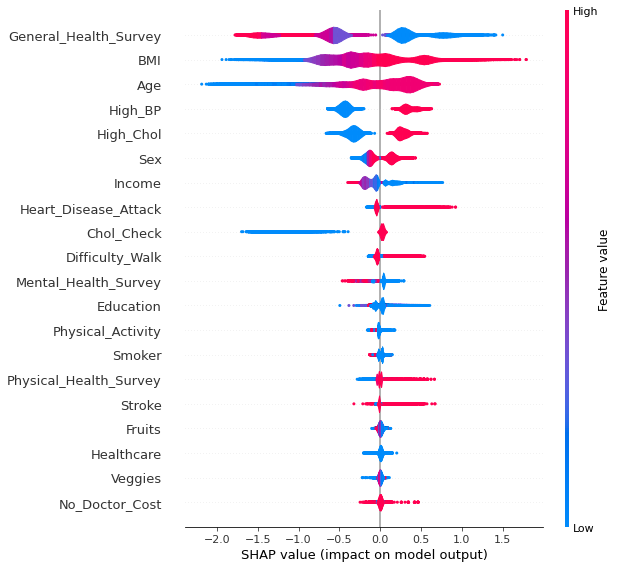

In [32]:
explainer = shap.TreeExplainer(undersampling[0])
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X_train,show=True,max_display=20,plot_type="violin")
plt.show()

##### SMOTE

Train AUC: 0.8282
Test AUC: 0.8248
Train Accuracy: 0.8399
Test Accuracy: 0.8373


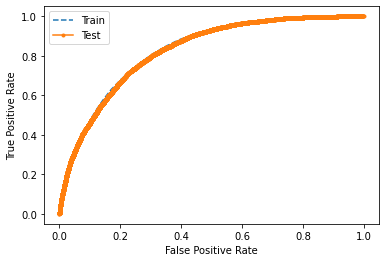

In [33]:
smote = imbalanced_evaluation(X_train,y_train,X_test,y_test,"smote")

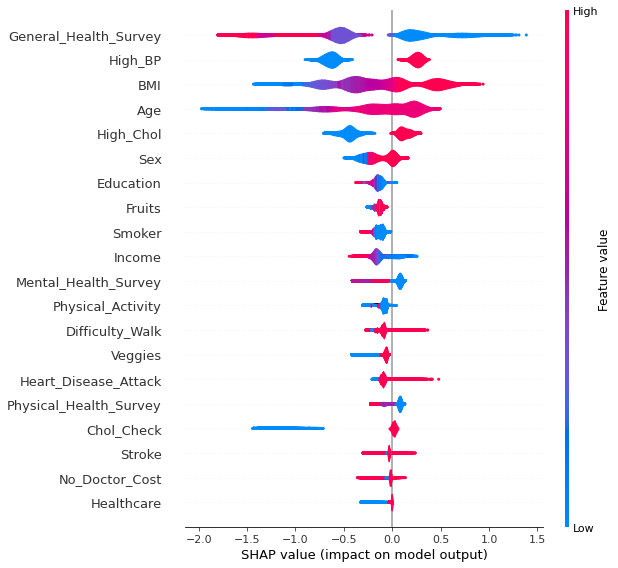

In [34]:
explainer = shap.TreeExplainer(smote[0])
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X_train,show=True,max_display=20,plot_type="violin")
plt.show()

##### Custom Undersampling + SMOTE

In [35]:
# Train/validation split (70/30) to prevent leakage
sss = StratifiedShuffleSplit(n_splits=1,test_size=.3,random_state=15774)
for train_index,val_index in sss.split(X_train,y_train):
    X_train_new,X_val = X_train.iloc[train_index],X_train.iloc[val_index]
    y_train_new,y_val = y_train.iloc[train_index],y_train.iloc[val_index]

In [36]:
%%capture

# Hyperparameter tuning

minority_class = 1
majority_class = 0

undersampling_ratios = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
smote_ratios = [.5,1.0,2.0,3.0,4.0,5.0]

best_auc = -np.inf
best_undersampling = None
best_smote = None

for i in undersampling_ratios:
    # Undersampling
    minority_class_n = (y_train_new==1).sum()
    majority_class_n = (y_train_new==0).sum()
    num_to_sample = int(i*majority_class_n)
    X_minority_class = X_train_new[y_train_new==minority_class]
    X_majority_class = resample(X_train_new[y_train_new==majority_class],
                                replace=False,
                                n_samples=num_to_sample)
    X_train_undersampled = pd.concat([X_minority_class,X_majority_class])
    y_train_undersampled = pd.concat([pd.Series([minority_class]*len(X_minority_class)),
                                      pd.Series([majority_class]*len(X_majority_class))])
    # SMOTE
    for j in smote_ratios:
        minority_class_n = (y_train_undersampled==1).sum()
        majority_class_n = (y_train_undersampled==0).sum()
        proportion_to_sample = min(1.0,((j*minority_class_n+minority_class_n)/(majority_class_n)))
        sm = SMOTE(random_state=15774,sampling_strategy=proportion_to_sample)
        X_train_smote,y_train_smote = sm.fit_resample(X_train_undersampled,y_train_undersampled)
        # Fit model
        param_grid = {"n_estimators": [100,200],
                      "max_depth": np.arange(2,6,1)}
        gs = GridSearchCV(xgb.XGBClassifier(eval_metric="logloss"),
                                            return_train_score=True, 
                                            param_grid=param_grid, 
                                            scoring="roc_auc",
                                            cv=5,
                                            verbose=0,
                                            n_jobs=-1)
        gs.fit(X_train_smote,y_train_smote)
        model = gs.best_estimator_    
        # Evaluation
        threshold = find_optimal_cutoff(y_train_smote,model.predict_proba(X_train_smote)[:,1])
        auc,accuracy = classification_evaluation(model,X_train_new,y_train_new,X_val,y_val,threshold)
        # Return best hyperparameters
        if auc > best_auc:
            best_auc = auc
            best_undersampling = i
            best_smote = j

In [37]:
# Print the best ratios
print("Optimal Undersampling Ratio:",best_undersampling)
print("Optimal SMOTE Ratio:",best_smote)

Optimal Undersampling Ratio: 0.7
Optimal SMOTE Ratio: 0.5


Train AUC: 0.8379
Test AUC: 0.8341
Train Accuracy: 0.7844
Test Accuracy: 0.7816


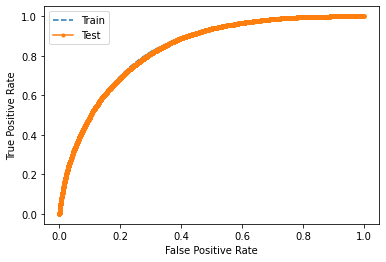

In [38]:
# Fit a final model using the best ratios
minority_class_n = (y_train==1).sum()
majority_class_n = (y_train==0).sum()
num_to_sample = int(best_undersampling*majority_class_n)
X_minority_class = X_train[y_train==minority_class]
X_majority_class = resample(X_train[y_train==majority_class],
                            replace=False,
                            n_samples=num_to_sample)
X_train_undersampled = pd.concat([X_minority_class,X_majority_class])
y_train_undersampled = pd.concat([pd.Series([minority_class]*len(X_minority_class)),
                                  pd.Series([majority_class]*len(X_majority_class))])
minority_class_n = (y_train_undersampled==1).sum()
majority_class_n = (y_train_undersampled==0).sum()
proportion_to_sample = min(1.0,((best_smote*minority_class_n+minority_class_n)/(majority_class_n)))
sm = SMOTE(random_state=15774,sampling_strategy=proportion_to_sample)
X_train_smote,y_train_smote = sm.fit_resample(X_train_undersampled,y_train_undersampled)
param_grid = {"n_estimators": [100,200],
              "max_depth": np.arange(2,6,1)}
gs = GridSearchCV(xgb.XGBClassifier(eval_metric="logloss"),
                                    return_train_score=True, 
                                    param_grid=param_grid, 
                                    scoring="roc_auc",
                                    cv=5,
                                    verbose=0,
                                    n_jobs=-1)
gs.fit(X_train_smote,y_train_smote)
model = gs.best_estimator_  
threshold = find_optimal_cutoff(y_train_smote,model.predict_proba(X_train_smote)[:,1])
auc,accuracy = classification_evaluation(model,X_train,y_train,X_test,y_test,threshold)
custom = (model,auc,accuracy)

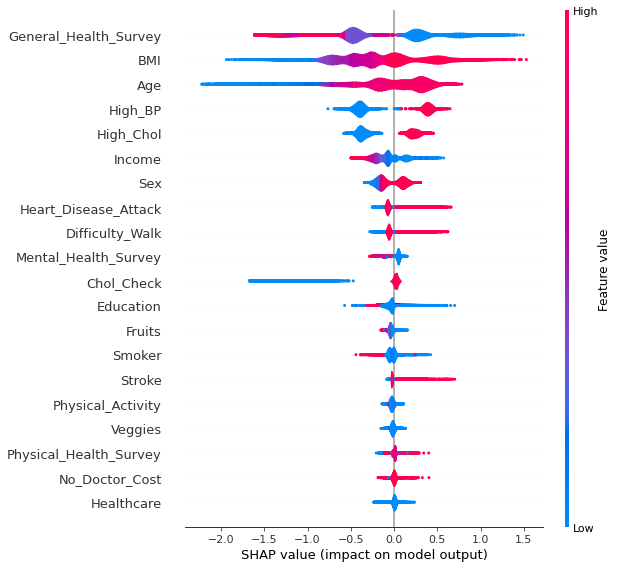

In [39]:
explainer = shap.TreeExplainer(custom[0])
shap_values = explainer.shap_values(X_train)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X_train,show=True,max_display=20,plot_type="violin")
plt.show()

# Final Results

In [40]:
names = ["Logistic Regression","Decision Tree","XGBoost",
         "XGBoost_Upsampling","XGBoost_Undersampling","XGBoost_SMOTE","XGBoost_Custom"]
auc_res = [m_lr_auc,m_cart_auc,m_xgb_auc,
           upsampling[1],undersampling[1],smote[1],custom[1]]
acc_res = [m_lr_accuracy,m_cart_accuracy,m_xgb_accuracy,
           upsampling[2],undersampling[2],smote[2],custom[2]]

pd.DataFrame({"Model":names,
              "Testing AUC":auc_res,
              "Testing Accuracy":acc_res}).sort_values(by="Testing AUC",ascending=False).reset_index(drop=True)

,Model,Testing AUC,Testing Accuracy
0,XGBoost_Custom,0.834081,0.781570
1,XGBoost,0.833296,0.754065
2,XGBoost_Undersampling,0.832764,0.749488
3,XGBoost_Upsampling,0.827980,0.761915
4,XGBoost_SMOTE,0.824774,0.837302
5,Logistic Regression,0.784348,0.712608
6,Decision Tree,0.783767,0.767557


In [41]:
print(f"--- Notebook Time: {time.time()-start_time:.0f} seconds ---")

--- Notebook Time: 6212 seconds ---
